**Pooya Kabiri - 96521434**

Importing prerequisites

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# Panorama Stitching

`stitch(image1, image2)`: Gets two images as input, stitchs them together using OpenCV `Stitcher.stitch()` method and returns the panorama.

In [3]:
def stitch(image1, image2):
    '''
    Creates panorama image of two inputs.
    
    Parameters:
        image1 (numpy.ndarray): The first input image.
        image2 (numpy.ndarray): The second input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''

    stitcher = cv2.Stitcher_create()
    status, stitched = stitcher.stitch([image1, image2])

    
    return stitched

Test your implementation (dont change this cell)

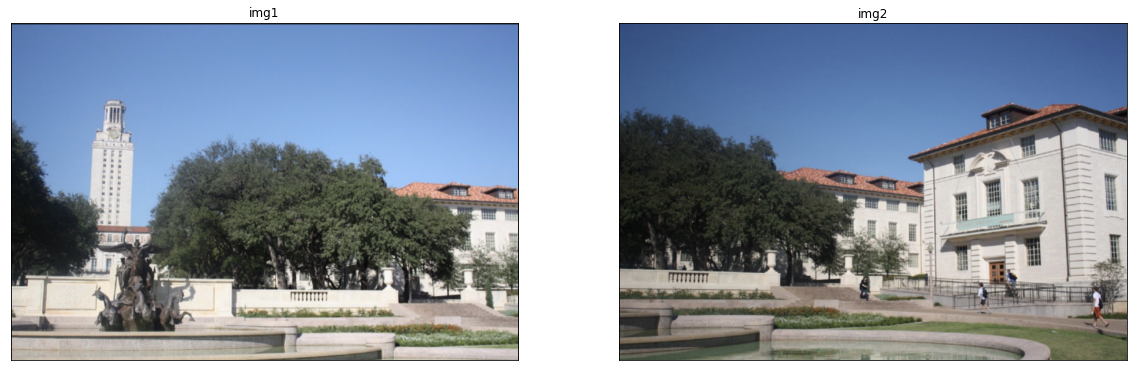

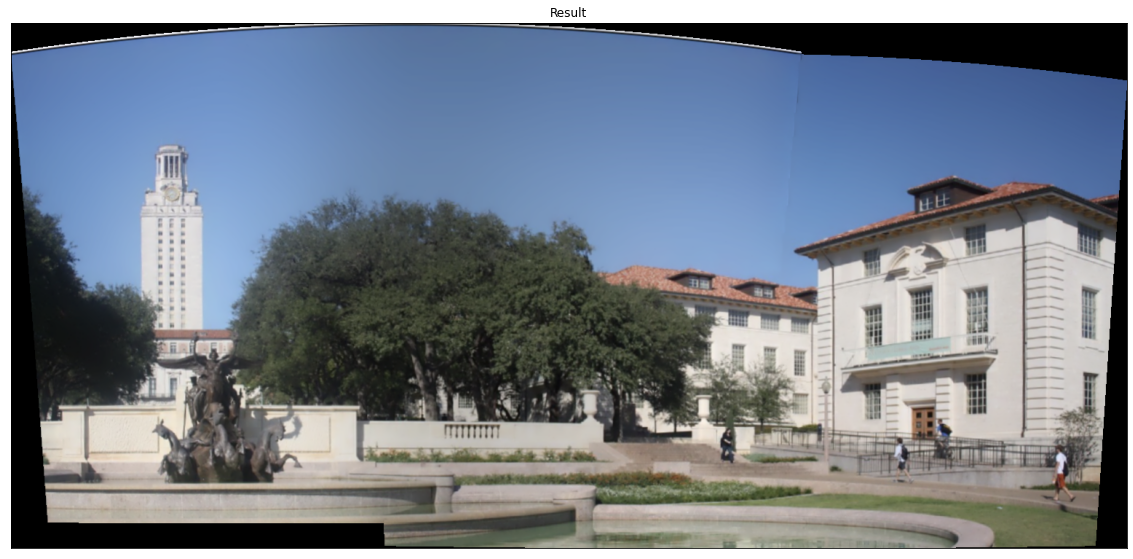

In [4]:
image_list = []

image1 = cv2.imread(os.path.join('images', '2a.png'))
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image_list.append([image1, 'img1', 'img'])

image2 = cv2.imread(os.path.join('images', '2b.png'))
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image_list.append([image2, 'img2', 'img'])

plotter(image_list, 1, 2, True, 20, 10, '2_1')

image_list = []
image_list.append([stitch(image1,image2), 'Result', 'img'])

plotter(image_list, 1, 1, True, 20, 10, '2_2')

# Mask Overlay

`put_mask(face, mask)`: gets a face image and a mask image as inputs. Uses dlib face detector and face landmark ddetector to recognize landmarks of the face. 4 of these landmarks (nose, chin, left and right part of ears) are chosen for mask transformation. Then, the mask image is transformed using these 4 pairs of landmark points. Finally, ther new mask image is applied onto the face image and the result is returned.

In [5]:
import dlib

def put_mask(face, mask):
    '''
    Adds mask image on face image.
    
    Parameters:
        face (numpy.ndarray): face image.
        mask (numpy.ndarray): mask image.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    image_size = (700, 700)
    result = face.copy()
    
    gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    
    detector = dlib.get_frontal_face_detector()
    face_detected = detector(gray, 1)
    
    print("Number of faces detected: ", len(face_detected))
    
    ### Data file downloaded from: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    path = 'shape_predictor_68_face_landmarks.dat'
    predictor = dlib.shape_predictor(path)
    
    ### Predict landmarks on found faces
    for f in face_detected:
        landmarks = predictor(gray, f)
    
    ### Indices are corressponding to 68 landmark detected using dlib
    face_landmark_indices = [30, 9, 3, 15]
    
    ### Coordinates of desired points on mask is calculated using https://www.makesense.ai
    mask_landmark_coordinates = np.array([
        [620, 102],
        [625, 700],
        [200, 220],
        [986, 209]
    ],np.float32)
        
    temp_list = []
    for n in face_landmark_indices:
        x = landmarks.part(n - 1).x
        y = landmarks.part(n - 1).y
        temp = np.array([x, y],np.float32)
        temp_list.append(temp)
        cv2.circle(face, (x, y), 4, (0, 0, 255), -1)
    
    face_landmark_coordinates = np.array(temp_list,np.float32)
    
    ### Calculating the projection transform matrix using OpenCV
    mat = cv2.getPerspectiveTransform(mask_landmark_coordinates, face_landmark_coordinates)
    
    ### Transform the mask image with the matrix calculated above
    mask_transformed = cv2.warpPerspective(mask, mat, image_size)
    
    ### Apply mask on the image
    for i in range(face.shape[0]):
        for j in range(face.shape[1]):
            if mask_transformed[i, j].all() > 0:
                result[i, j] = mask_transformed[i, j]

    return result

Test of implementation.

Number of faces detected:  1


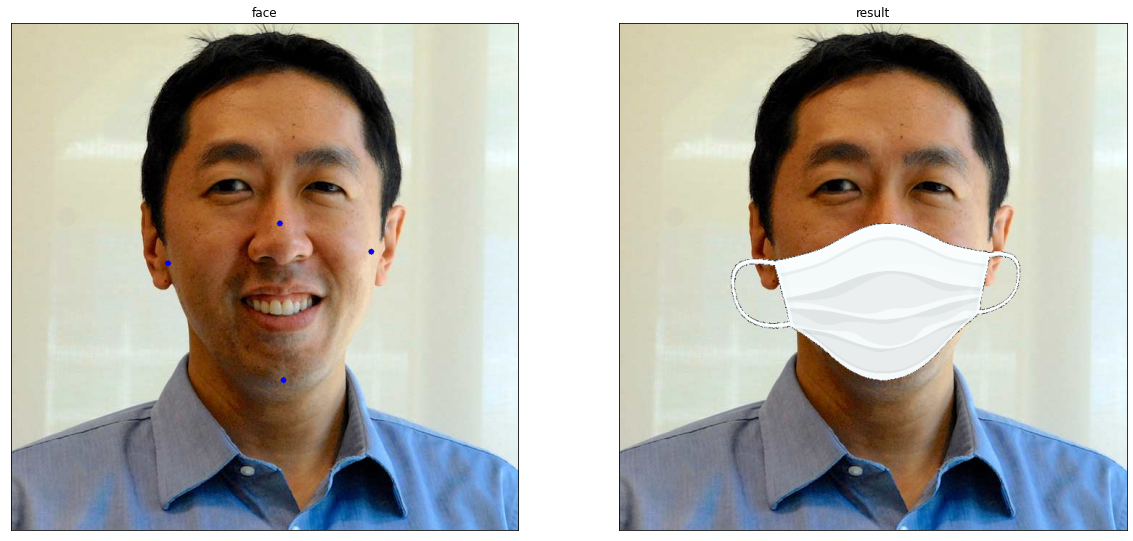

In [6]:
image_list = []

face = cv2.imread(os.path.join('images', 'face.jpg'))
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
image_list.append([face, 'face', 'img'])

mask = cv2.imread(os.path.join('images', 'mask.jpg'))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)



image_list.append([put_mask(face, mask), 'result', 'img'])

plotter(image_list, 1, 2, True, 20, 10, '3')

**As seen,** the 4 landmarks are shown in blue, and after applying the mask, the points are exactly mapped into the corressponding points on the mask.
